# AR and MA models for Tractor Sales

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#### 1. Import and prepare the dataset (cf. TractorSales.ipynb).

In [2]:
# Loading the Data
df = pd.read_csv('TractorSales.csv', sep=',')
df['date'] = pd.date_range(start='2003-01-01', freq='MS', periods=len(df))
df['sold'] = df.iloc[:,1]
df1 = df.loc[:, ['date', 'sold']].copy()
df1['log_sold'] = np.log(df1['sold'])
df1['log_sold_diff'] = df1.log_sold.diff().diff(periods=12)
df1
tractor = df1.set_index('date')[['log_sold_diff']].dropna()
tractor

,log_sold_diff
date,
2004-02-01,0.039744
2004-03-01,-0.004870
2004-04-01,-0.018615
2004-05-01,-0.010332
2004-06-01,0.066686
...,...
2014-08-01,-0.047407
2014-09-01,0.013533
2014-10-01,0.031194


#### 2. Use a PACF plot to determine the order p of the AR(p) model

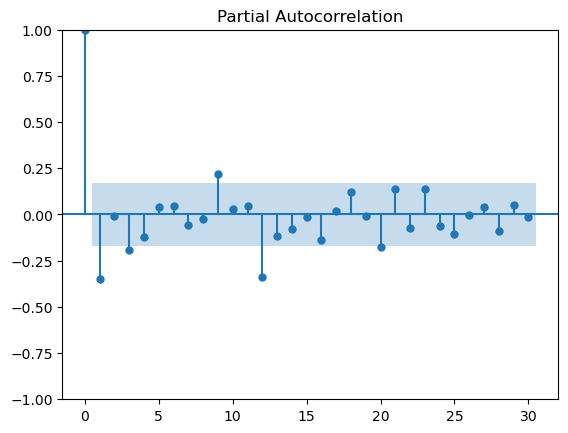

In [3]:
# PACF plot
plot_pacf(tractor, lags=30)
plt.show()

We choose $p=1$. $p = 3, 9$ or $12$ would also be ok. We'll compare these models later.

#### 3. Fit an AR(p) model

In [4]:
# Fit an AR(1) model to the time series
tractorAR1 = AutoReg(tractor, lags=1).fit()
print(tractorAR1.summary())

                            AutoReg Model Results                             
Dep. Variable:          log_sold_diff   No. Observations:                  131
Model:                     AutoReg(1)   Log Likelihood                 225.514
Method:               Conditional MLE   S.D. of innovations              0.043
Date:                Fri, 12 Sep 2025   AIC                           -445.028
Time:                        13:28:18   BIC                           -436.426
Sample:                    03-01-2004   HQIC                          -441.533
                         - 12-01-2014                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0001      0.004      0.029      0.977      -0.007       0.007
log_sold_diff.L1    -0.3515      0.082     -4.294      0.000      -0.512      -0.191
                            

/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### 4. Perform model diagnostics for this model

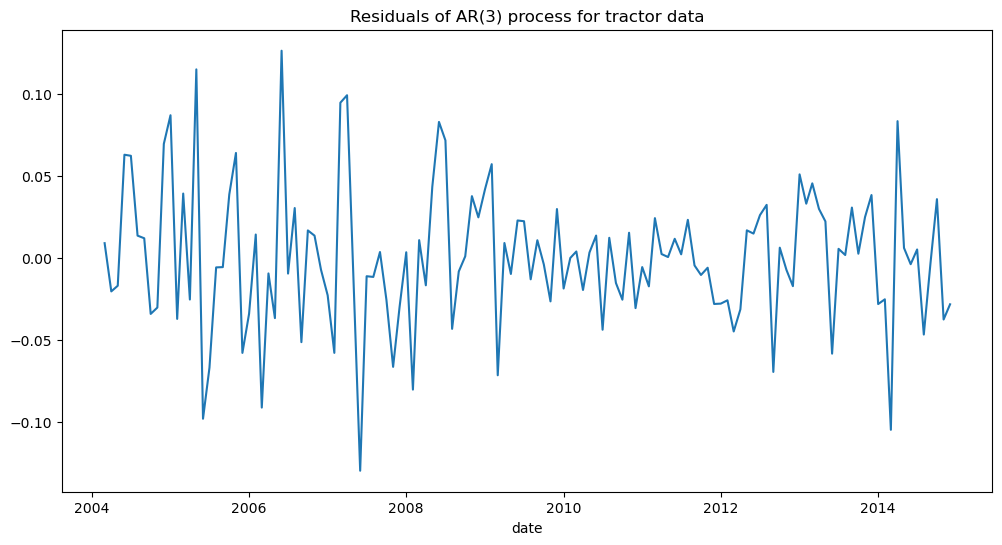

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(tractorAR1.resid)
plt.title('Residuals of AR(3) process for tractor data')
plt.show()

The residuals look ok. However, the variance is not constant.

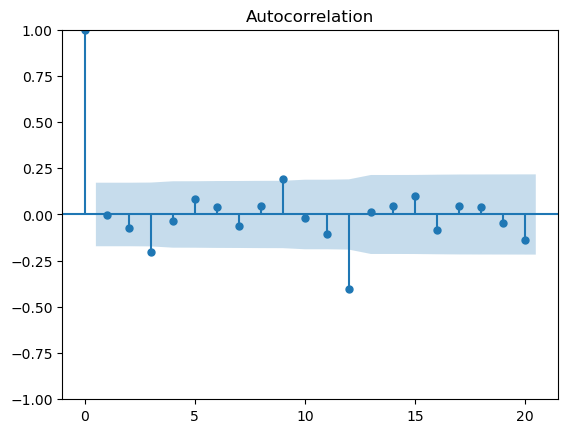

In [6]:
# ACF and PACF of residuals to check if they resemble white noise
plot_acf(tractorAR1.resid, lags=20)
plt.show()

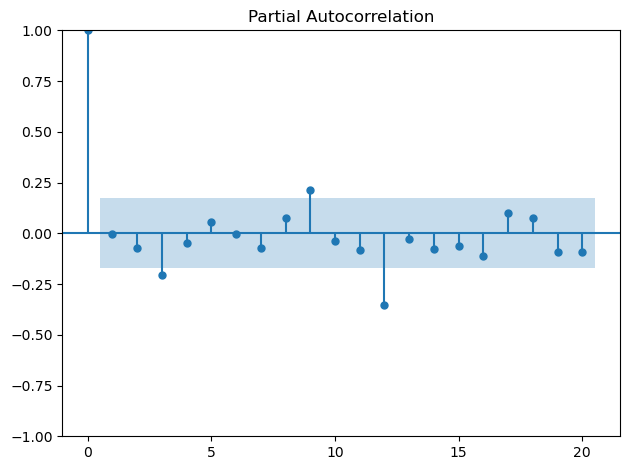

In [7]:
plot_pacf(tractorAR1.resid, lags=20)
plt.tight_layout()
plt.show()

Some of the correlations differ significantly from zero. The model fit is not perfect.

In [8]:
# Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(tractorAR1.resid)

,lb_stat,lb_pvalue
1,0.002379,0.961098
2,0.674187,0.713842
3,6.252044,0.099971
4,6.405483,0.170844
5,7.354151,0.195606
6,7.597602,0.269090
7,8.182757,0.316755
8,8.464228,0.389484
9,13.678081,0.134246
10,13.738195,0.185272


The p-values are > 0.05. The test therefore gives us no reason to assume that the residuals are not independent.

#### 5. Use an ACF plot to determine the order q of the MA(q) model

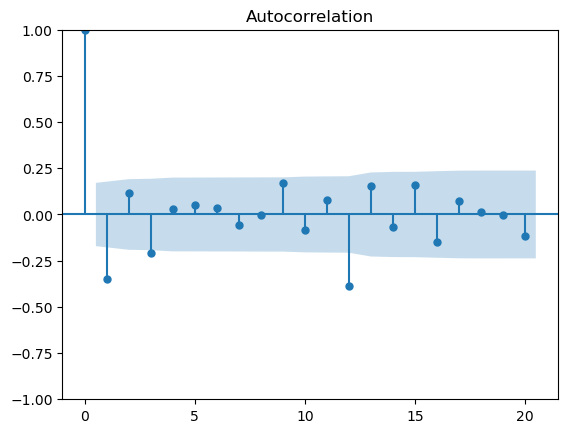

In [9]:
# PACF plot
plot_acf(tractor, lags=20)
plt.show()

We choose $q=12$. $q = 1$ or $3$ would also be ok. We'll compare these models later.

#### 6. Fit an MA(q) model

In [10]:
# Fit an MA(1) Model
tractorMA12 = ARIMA(tractor, order=(0, 0, 12)).fit()
print(tractorMA12.summary())

/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          log_sold_diff   No. Observations:                  131
Model:                ARIMA(0, 0, 12)   Log Likelihood                 250.209
Date:                Fri, 12 Sep 2025   AIC                           -472.419
Time:                        13:28:20   BIC                           -432.166
Sample:                    02-01-2004   HQIC                          -456.062
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.414      0.679      -0.002       0.001
ma.L1         -0.2953      0.144     -2.051      0.040      -0.578      -0.013
ma.L2          0.0182      0.142      0.128      0.8

/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 7. Perform model diagnostics for this model

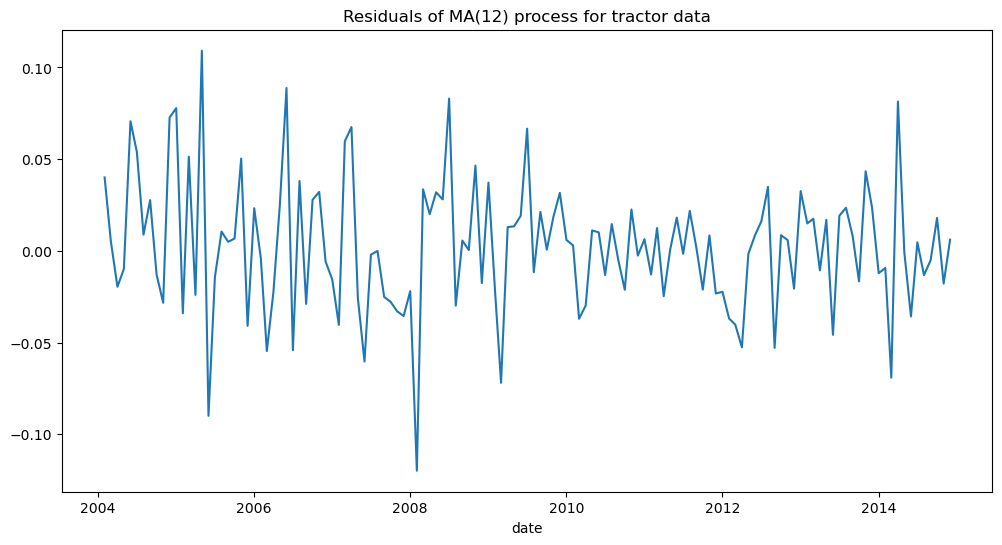

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(tractorMA12.resid)
plt.title('Residuals of MA(12) process for tractor data')
plt.show()

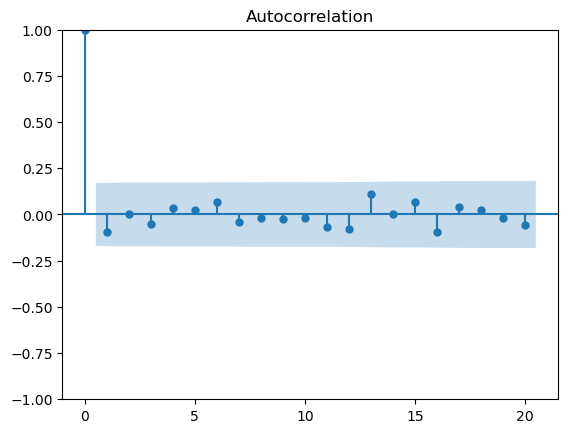

In [12]:
# ACF and PACF of residuals to check if they resemble white noise
plot_acf(tractorMA12.resid, lags=20)
plt.show()

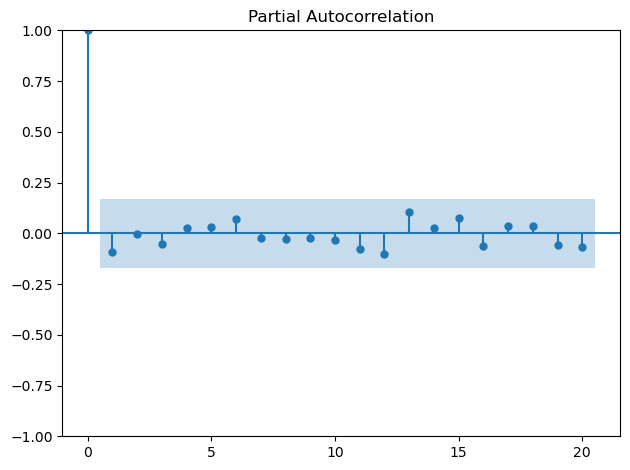

In [13]:
plot_pacf(tractorMA12.resid, lags=20)
plt.tight_layout()
plt.show()

The residuals look ok.

In [14]:
# Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(tractorMA12.resid)

,lb_stat,lb_pvalue
1,1.144626,0.284677
2,1.147387,0.563441
3,1.537517,0.673639
4,1.731524,0.784984
5,1.809925,0.874770
6,2.452118,0.873787
7,2.688576,0.912241
8,2.754648,0.948799
9,2.826978,0.970761
10,2.890579,0.983883


The p-values are > 0.05. The test therefore gives us no reason to assume that the residuals are not independent.

#### 8. Fit more AR(p) and MA(q) models with reasonable values for  p and q respectively. Use AIC to compare the models and choose your favorite model.


In [15]:
# Fit AR models for p = 3, 9 and 12
tractorAR3 = AutoReg(tractor, lags=3).fit()
tractorAR9 = AutoReg(tractor, lags=9).fit()
tractorAR12 = AutoReg(tractor, lags=12).fit()

# Fit MA models for q = 3 and 12
tractorMA1 = ARIMA(tractor, order=(0, 0, 1)).fit()
tractorMA3 = ARIMA(tractor, order=(0, 0, 3)).fit()

/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

In [16]:
print(f'AIC for AR(1): {tractorAR1.aic}')
print(f'AIC for AR(3): {tractorAR3.aic}')
print(f'AIC for AR(9): {tractorAR9.aic}')
print(f'AIC for AR(12): {tractorAR12.aic}')

print(f'AIC for MA(1): {tractorMA1.aic}')
print(f'AIC for MA(3): {tractorMA3.aic}')
print(f'AIC for MA(12): {tractorMA12.aic}')

AIC for AR(1): -445.0281370238921
AIC for AR(3): -437.1643420262176
AIC for AR(9): -413.0781590946185
AIC for AR(12): -421.7289676158758
AIC for MA(1): -449.2876200293158
AIC for MA(3): -450.2822317428878
AIC for MA(12): -472.4188301414532


We prefer the MA(12) model because it has the lowest AIC and diagnostics do not speak against this model. 